In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [12]:
class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)

In [2]:
# MLP with softPlus head, to ensure positivity of rate
class MLP_rate(nn.Module):
    def __init__(self, base_mlp):
        super().__init__(); self.base = base_mlp
    def forward(self, x):
        return F.softplus(self.base(x))

# 1. Generate Data

- Source: $X_0 \sim Poisson(\lambda_0)$, with $\lambda_0 \sim Gamma_0$
- Target: $X_1 \sim Poisson(\lambda_1)$, with $\lambda_1 \sim 0.5Gamma_{11} + 0.5Gamma_{12}$

In [3]:
np.random.seed(0)
N = 1000

# source
k     = np.array([10.0, 20.0])
rate  = np.array([1.0, 1.0])
lam0 = np.random.gamma(shape=k, scale=1.0 / rate, size=(N, 2))
X0   = np.random.poisson(lam0) 


k    = np.array([[60.0, 5.0],  [60.0, 40.0]])   # shapes for comp 0 and 1 (2 dims)
rate = np.array([[1.0, 1.0],  [1.0, 1.0]])   # rates  for comp 0 and 1 (2 dims)
z = (np.random.rand(N) < 0.5).astype(int)    # 50/50 mixture labels
lam1 = np.random.gamma(shape=k[z], scale=1.0/rate[z])  # λ ~ 0.5*Gamma0 + 0.5*Gamma1
X1 = np.random.poisson(lam1)

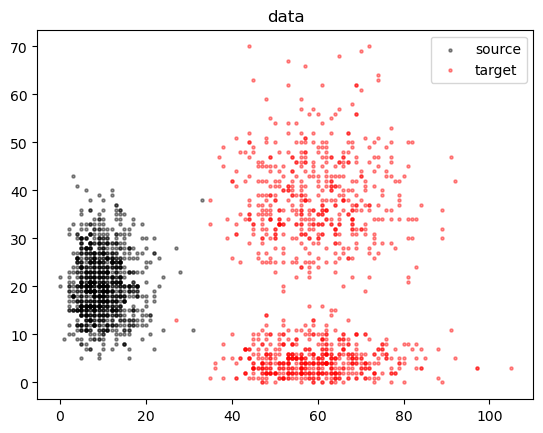

In [4]:
alpha_pt = 0.4
plt.scatter(X0[:,0], X0[:,1], c = 'k', s = 5, alpha = alpha_pt, label = 'source');
plt.scatter(X1[:,0], X1[:,1], c = 'r', s = 5, alpha = alpha_pt, label = 'target');
plt.title('data');
plt.legend();

# 2. Training

## 2.1 Some training functions

In [5]:
def sample_xt(x0, x1, t):
    with torch.no_grad():
        diff = x1 - x0                     # [B,d]
        sign = torch.sign(diff)
        n    = diff.abs()                  # [B,d], integer counts

        # broadcast t to [B,d]
        t_full = t.expand_as(n)

        # faster binomial sampling; returns float
        b = torch.binomial(n.float(), t_full)   # [B,d]

        return x0 + sign * b.to(x0.dtype)

In [6]:
def sample_rt(xt, x1, t, eps_t):
    # **un-normalized**
    # birth: lambda_t = |x1 - xt|/(1-t)
    # death: mu_t = |xt - x1|/(1-t)
    
    with torch.no_grad():
        idx_b = (x1 > xt).to(torch.float32) # birth id
        idx_d = (xt > x1).to(torch.float32) # death id
        idx_0 = (xt <= 0).to(torch.float32) # boundary, no death

        lambda_star = idx_b * (x1 - xt) / (1.0 - t + eps_t)        
        mu_star = idx_d * (xt - x1) / (1.0 - t + eps_t)*(1 - idx_0)
        
        # concatenate: [\lambda_{1:d}, \mu_{1:d}]
        rates_star = torch.cat([lambda_star, mu_star], dim=1)
        
        return rates_star, idx_0

In [7]:
def model_forward(xt_t, separate_heads, nets, d, idx_0):
    if not separate_heads:
        out = nets(xt_t)
        lambda_theta, beta_theta = out[:, :d], out[:, d:]
    else:
        net_b = nets[0]
        net_d = nets[1]
        lambda_theta = net_b(xt_t)
        beta_theta = net_d(xt_t)
        
    mu_theta = (xt_t[:, :d] * beta_theta) * (1.0 - idx_0)
    rates_theta = torch.cat([lambda_theta, mu_theta], dim=1)
    return rates_theta

In [8]:
def model_loss(loss_mode, rates_theta, rates_star):
    if loss_mode == "l2":
        loss = ((rates_theta - rates_star)**2).sum(dim=1).mean()
    else:
        u = rates_star
        v = rates_theta

        loss = (v - u*torch.log(v + eps_log)).sum(1).mean()
        # loss = (u * (torch.log(u + eps_log) - torch.log(v + eps_log)) + v - u).sum(1).mean()
    
    return loss

## 2.2 Preperation

In [9]:
X0_torch = torch.tensor(X0)
X1_torch = torch.tensor(X1)
N0, d = X0_torch.shape
N1, _ = X1_torch.shape

Here, both L2 and Poisson deviance are implemented.

Intuitively, the Poisson deviance should correspond to ELBO (to show later).

In [10]:
# some training settings
batch_size = 256
num_epochs = 10000
steps_per_epoch = (max(N0, N1) + batch_size - 1) // batch_size

eps_t = 1e-4 # add some eps to avoid rate blow up for t = 1
eps_log = 1e-8 # for Poisson deviance...

lr = 1e-3
loss_mode = 'poisson' # or 'poisson'/ 'l2'

In [13]:
##  networks: MLP with softplus head
# can be shared/ separate for birth & death
separate_heads = False
if not separate_heads:
    net_base = MLP(dim=d, out_dim=2*d, w=64, time_varying=True).to(device)
    net = MLP_rate(net_base)
    params = list(net.parameters())
    nets = net
    
if separate_heads:
    net_base_b = MLP(dim=d, out_dim=d, w=64, time_varying=True).to(device)  # births
    net_base_d = MLP(dim=d, out_dim=d, w=64, time_varying=True).to(device)  # deaths
    net_b = MLP_rate(net_base_b)
    net_d = MLP_rate(net_base_d)
    params = list(net_b.parameters()) + list(net_d.parameters())
    nets = [net_b, net_d]
    
optimizer = torch.optim.Adam(params, lr=lr)

## 2.3 Begin to train!

In [14]:
for epoch in tqdm(range(num_epochs)):
    for step in range(steps_per_epoch):

        # 1. sample data pair
        idx0 = torch.randint(0, N0, (batch_size,), device=device)
        idx1 = torch.randint(0, N1, (batch_size,), device=device)
        x0 = X0_torch[idx0]
        x1 = X1_torch[idx1]

        # 2. sample time U[0,1], use eps_t to avoid 1/0
        t = torch.rand(batch_size, 1, device=device)*(1-2*eps_t) + eps_t

        # 3. sample xt = x0 +/- Bin(|x1 - x0|, t)
        xt = sample_xt(x0, x1, t)
        
        # 4. calcu conditional rate
        rates_star, idx_0 = sample_rt(xt, x1, t, eps_t)
        
        # 5. model forward
        xt_t = torch.cat([xt, t], dim=1)
        rates_theta = model_forward(xt_t, separate_heads, nets, d, idx_0)

        # 6. calculate loss
        loss = model_loss(loss_mode, rates_theta, rates_star)

        # 7. backprop
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # 8. log
    if epoch % (num_epochs//5) == 0:
        print(f"[epoch {epoch}] loss={float(loss):.6f}")

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/ganchao/miniconda3/envs/vfm/lib/python3.9/site-packages/torch/utils/_device.py:103: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return func(*args, **kwargs)
  0%|                                       | 23/10000 [00:00<01:15, 131.39it/s]

[epoch 0] loss=-51.225479


 20%|███████▌                             | 2030/10000 [00:09<00:38, 209.65it/s]

[epoch 2000] loss=-165.792023


 40%|██████████████▉                      | 4031/10000 [00:19<00:28, 207.64it/s]

[epoch 4000] loss=-172.462524


 60%|██████████████████████▎              | 6038/10000 [00:29<00:20, 190.92it/s]

[epoch 6000] loss=-176.714813


 80%|█████████████████████████████▋       | 8027/10000 [00:39<00:09, 207.07it/s]

[epoch 8000] loss=-164.378906


100%|████████████████████████████████████| 10000/10000 [00:49<00:00, 203.38it/s]


# 3. Sampling

let's simply do Euler/ Bernoulli jump for each dimension independently:

1. In each step, $p(no-jump| x_t, \delta t) = exp(-r_t\delta t)$
2. So, $p(jump| x_t, \delta t) = 1- exp(-r_t\delta t)$
3. Once we decide to jump: decide +1 (birth) or -1 (death)


In [15]:
# corresponding function
def sample_euler(nets, n_step, x0, device, eps_t = 1e-4, eps_log = 1e-8, separate_heads=False):
    xt = x0.to(device=device, dtype=torch.float32).clone()
    N, d = xt.shape
    t = torch.full((N, 1), eps_t, device=device, dtype=torch.float32)
    Delta = torch.tensor((1.0 - 2.0*eps_t) / float(n_step),
                         device=device, dtype=torch.float32)
    traj = torch.empty(n_step + 1, N, d, device=device, dtype=torch.float32)
    traj[0] = xt

    for s in range(n_step):
        xt_t = torch.cat([xt, t], dim=1)
        if not separate_heads:
            out = nets(xt_t)  # [N, 2d]
            lambda_theta, beta_theta = out[:, :d], out[:, d:]
        else:
            lambda_theta = nets[0](xt_t)  # [N, d]
            beta_theta = nets[1](xt_t)  # [N, d]

        idx_0 = (xt <= 0).to(torch.float32)         # no death at 0
        mu_theta = (xt * beta_theta) * (1.0 - idx_0)

        r_i = (lambda_theta + mu_theta)             # [N, d]
        p_none = torch.exp(-r_i * Delta)            # stay
        p_jump = 1.0 - p_none                       # jump

        p_birth = p_jump * (lambda_theta / (r_i + eps_log))
        p_death = p_jump * (mu_theta     / (r_i + eps_log))
        probs3 = torch.stack([p_none, p_birth, p_death], dim=-1)  # [N,d,3]

        probs3_flat = probs3.reshape(-1, 3)
        choice = torch.multinomial(probs3_flat, 1).view(N, d)

        adj = (choice == 1).to(torch.float32) - (choice == 2).to(torch.float32)
        xt = torch.clamp(xt + adj, min=0.0)

        t = torch.minimum(t + Delta, torch.full_like(t, 1.0 - eps_t))
        traj[s + 1] = xt

    x1_samples = xt.to(torch.long)
    return x1_samples, traj

## 3.1 new starting points

In [16]:
np.random.seed(123)
N_new = 1000
k     = np.array([10.0, 20.0])
rate  = np.array([1.0, 1.0])
lam0 = np.random.gamma(shape=k, scale=1.0 / rate, size=(N_new, 2))
X0_new   = np.random.poisson(lam0) 
x0_new_torch = torch.tensor(X0_new)

## 3.2 Generation

In [17]:
n_step = 2000
x1_samples, traj = sample_euler(nets, n_step, x0_new_torch, device, eps_t, eps_log, separate_heads)

## 3.3 plot the results

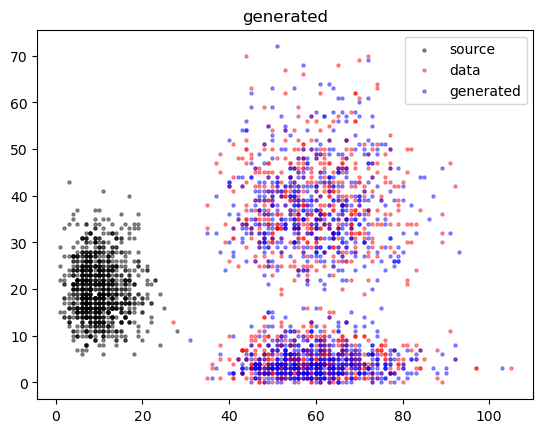

In [18]:
alpha_pt = 0.4
x1_new_np = x1_samples.detach().cpu().numpy()

plt.scatter(X0_new[:,0], X0_new[:,1], c = 'k', s = 5, alpha = alpha_pt, label = 'source');
plt.scatter(X1[:,0], X1[:,1], c = 'r', s = 5, alpha = alpha_pt, label = 'data');
plt.scatter(x1_new_np[:,0], x1_new_np[:,1], c = 'b', s = 5, alpha = alpha_pt, label = 'generated');
plt.title('generated');
plt.legend();

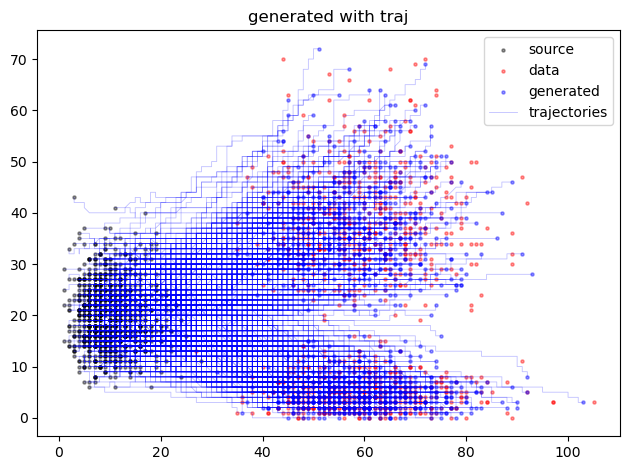

In [19]:
traj_np = traj.detach().cpu().numpy()         # [T+1, N, 2]
K = N                              # show K paths
perm = np.random.permutation(N)[:K]

plt.scatter(X0_new[:,0], X0_new[:,1], c='k', s=5, alpha=alpha_pt, label='source')
plt.scatter(X1[:,0],     X1[:,1],     c='r', s=5, alpha=alpha_pt, label='data')
plt.scatter(x1_new_np[:,0], x1_new_np[:,1], c='b', s=5, alpha=alpha_pt, label='generated')

for i in perm: plt.plot(traj_np[:, i, 0],
                        traj_np[:, i, 1],
                        linewidth=0.6, alpha=0.25, color='b')

plt.plot([], [], color='b', linewidth=0.6, alpha=0.25, label='trajectories')  # legend handle
plt.title('generated with traj')
plt.legend()
plt.tight_layout()

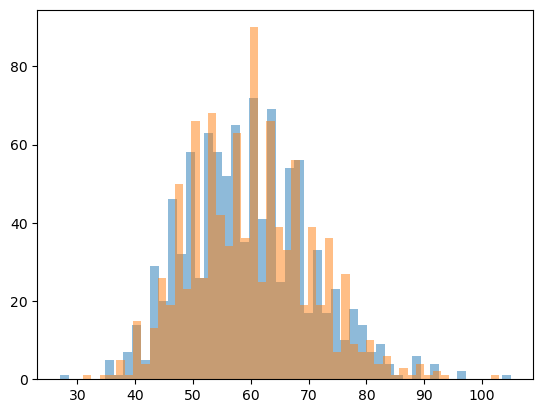

In [20]:
plt.hist(X1[:,0], 50, alpha = 0.5);
plt.hist(x1_new_np[:,0], 50, alpha = 0.5);